In [18]:
import os
import sys
sys.path.append('/Users/aghavamp/Desktop/Projects')
sys.path.append('/Users/aghavamp/Desktop/Projects/bimanual_wrist')

from pathlib import Path
import glob
import getpass
import importlib
import tqdm

import numpy as np
import pandas as pd
import scipy.io as sio

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.cm import ScalarMappable
import matplotlib.cm as cm
import matplotlib.colors as mcolors

import utils
importlib.reload(utils)

# SET PATHS:
baseDir = os.path.join('/Users', getpass.getuser(), 'Desktop', 'Projects', 'bimanual_wrist')
fMRI_behavDir = os.path.join(baseDir,'data','fMRI','behavioural')
train_behavDir = os.path.join(baseDir,'data','training')
anaDir = os.path.join(baseDir,'analysis')
figDir = os.path.join(baseDir,'figures')

path = {'baseDir': baseDir,
        'fMRI_behavDir': fMRI_behavDir,
        'train_behavDir': train_behavDir,
        'anaDir': anaDir}



# Average trajectories for unimanual conditions

In [ ]:
sn_list = [101, 104, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115]
D = pd.read_csv(os.path.join(anaDir, f's{101}_scan.csv'))
conds = D.cond_name.unique()

avg_traj = {'sn': [], 'cond': [], 'avg_x_l': [], 'avg_y_l': [], 'avg_x_r': [], 'avg_y_r': []}
for cond in conds:
    for sn in sn_list:
        D = pd.read_csv(os.path.join(anaDir, f's{sn}_scan.csv'))
        D = D[D.GoodMovement == 1]
        D_mov = pd.read_csv(os.path.join(anaDir, f's{sn}_scan_mov.csv'))

        left_conds = [tmp for tmp in conds if 'left_' in tmp]
        right_conds = [tmp for tmp in conds if 'right_' in tmp]
    
        BNs = D.BN[D.cond_name==cond].values.flatten()
        TNs = D.TN[D.cond_name==cond].values.flatten()
        
        # average the trajectories across all trials of the same condition:
        n_trials = len(BNs)
        subj_avg = {'x_l': np.full((n_trials, 10000), np.nan), 
                    'y_l': np.full((n_trials, 10000), np.nan), 
                    'x_r': np.full((n_trials, 10000), np.nan), 
                    'y_r': np.full((n_trials, 10000), np.nan)}
        for i in range(len(BNs)):
            BN = BNs[i]
            TN = TNs[i]
            idx_gocue = D.idx_gocue[(D.BN==BN) & (D.TN==TN)].values[0]
            idx_endReach = D.idx_endReach[(D.BN==BN) & (D.TN==TN)].values[0]
            idx_endReach = int(np.median(D.idx_endReach.values))
            # idx_endReach = np.max([idx_endReach, 480])
            
            # kinematic traces:
            trial_mov = D_mov[(D_mov.BN==BN) & (D_mov.TN==TN)]
            radius_l = trial_mov['mov_5'].values.flatten()[idx_gocue:idx_endReach]
            radius_r = trial_mov['mov_6'].values.flatten()[idx_gocue:idx_endReach]
            angle_l = trial_mov['mov_7'].values.flatten()[idx_gocue:idx_endReach]
            angle_r = trial_mov['mov_8'].values.flatten()[idx_gocue:idx_endReach]
            
            radius = 5
            x_offset = radius + 2
            y_offset = 0
            x_l = radius_l * np.cos(np.deg2rad(angle_l)) - x_offset
            y_l = radius_l * np.sin(np.deg2rad(angle_l)) + y_offset
            x_r = radius_r * np.cos(np.deg2rad(angle_r)) + x_offset
            y_r = radius_r * np.sin(np.deg2rad(angle_r)) + y_offset

            subj_avg['x_l'][i,:len(x_l)] = x_l
            subj_avg['y_l'][i,:len(y_l)] = y_l
            subj_avg['x_r'][i,:len(x_r)] = x_r
            subj_avg['y_r'][i,:len(y_r)] = y_r
        
        avg_x_l = np.nanmean(np.array(subj_avg['x_l']), axis=0)
        avg_y_l = np.nanmean(np.array(subj_avg['y_l']), axis=0)
        avg_x_r = np.nanmean(np.array(subj_avg['x_r']), axis=0)
        avg_y_r = np.nanmean(np.array(subj_avg['y_r']), axis=0)

        # remove nans at the end:
        valid_idx = np.where(~np.isnan(avg_x_l))[0]
        avg_x_l = avg_x_l[valid_idx]
        avg_y_l = avg_y_l[valid_idx]
        avg_x_r = avg_x_r[valid_idx]
        avg_y_r = avg_y_r[valid_idx]

        avg_traj['sn'].append(sn)
        avg_traj['cond'].append(cond)
        avg_traj['avg_x_l'].append(avg_x_l)
        avg_traj['avg_y_l'].append(avg_y_l)
        avg_traj['avg_x_r'].append(avg_x_r)
        avg_traj['avg_y_r'].append(avg_y_r)    
    
df = pd.DataFrame(avg_traj)
df.to_pickle(os.path.join(anaDir, 'avg_traj.pkl'))

D



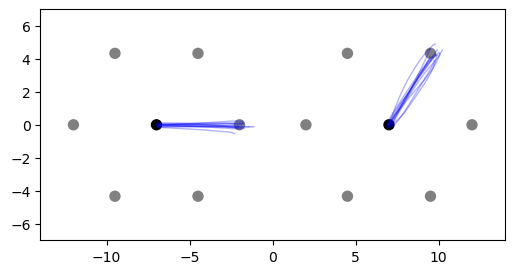

In [40]:
df = pd.read_pickle(os.path.join(anaDir, 'avg_traj.pkl'))
conds = df.cond.unique()

for cond in conds:
    df_cond = df[(df.cond==cond)]
    fix, ax = plt.subplots(figsize=(6, 3))
    for i, row in df_cond.iterrows():
        plt.plot(row['avg_x_l'], row['avg_y_l'], color='blue', alpha=0.3, lw=1)
        plt.plot(row['avg_x_r'], row['avg_y_r'], color='blue', alpha=0.3, lw=1)
    utils.please.draw_board(ax=ax, radius=5)
    ax.set_xlim(-14, 14)
    ax.set_ylim(-7, 7)
    # save figure:
    plt.savefig(os.path.join(figDir, 'reach_trajectories', 'train', f'{cond}.pdf'), bbox_inches="tight")
    if cond == 'bimanual_0_60': # show for one of the conditions as an example
        plt.show()
    else:
        plt.close()




# Bimanual vs Unimanual Equivalent Movement

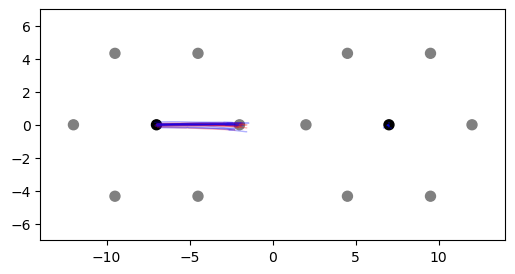

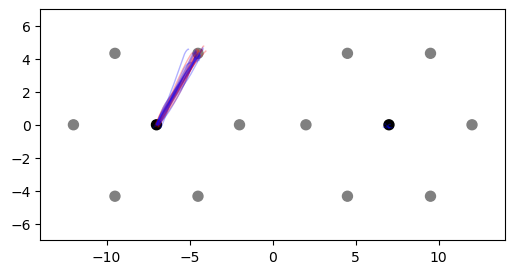

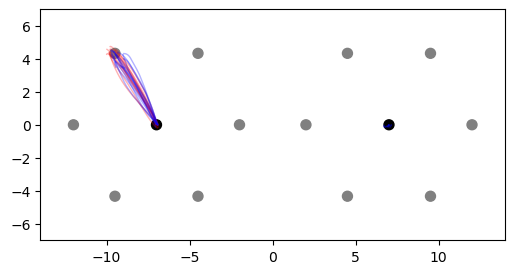

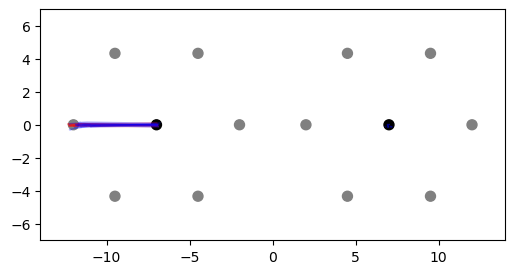

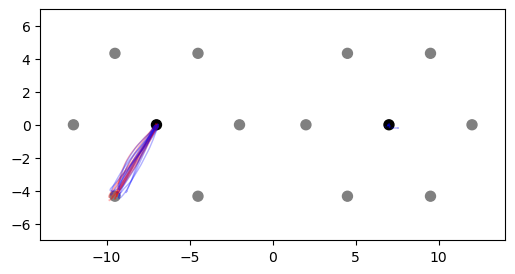

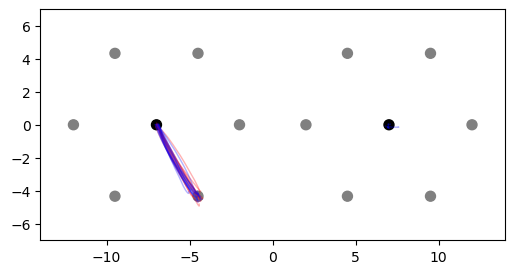

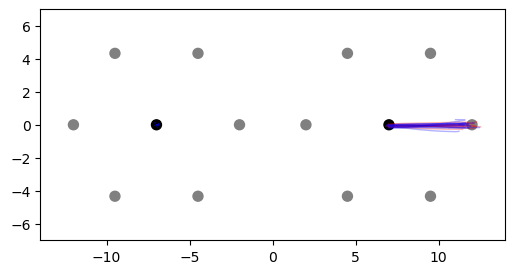

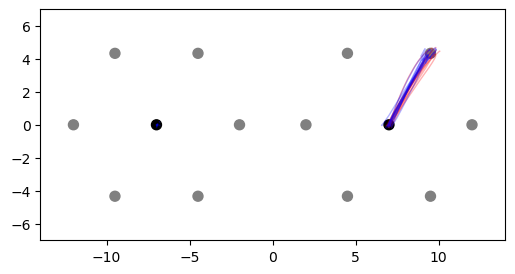

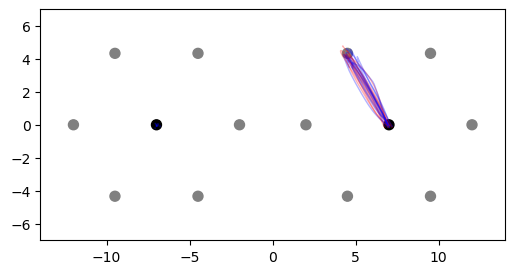

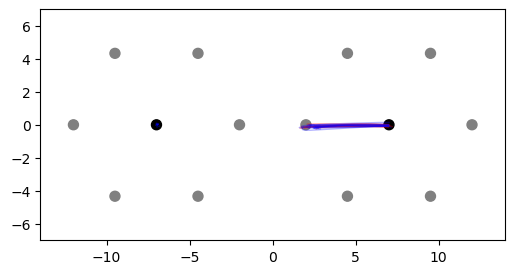

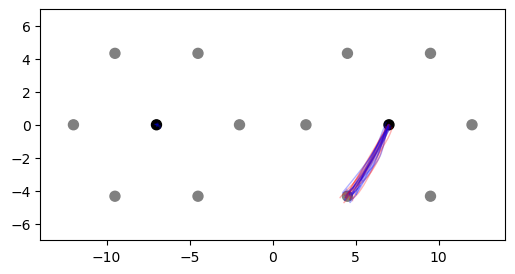

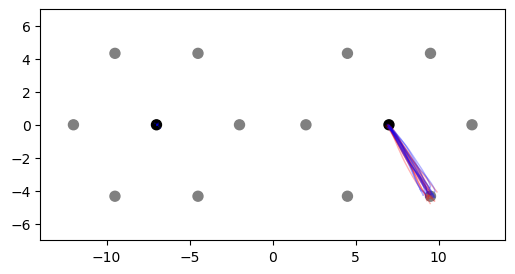

In [36]:
df = pd.read_pickle(os.path.join(anaDir, 'avg_traj.pkl'))
conds = df.cond.unique()
uni_conds = ['left_0', 'left_60', 'left_120', 'left_180', 'left_240', 'left_300',
             'right_0', 'right_60', 'right_120', 'right_180', 'right_240', 'right_300']

def mean_of_arrays(series):
    return np.mean(np.stack(series.values), axis=0)

for cond in uni_conds:
    df_uni = df[(df.cond==cond)]
    cond_angle = cond.split('_')[1]
    if 'left' in cond:
        # select bimanual conditoins in form of 'bimanual_cond.split('_')[1]_xx'
        df_bimanual = df[df.cond.str.contains('bimanual') & df.cond.str.startswith(f'bimanual_{cond_angle}')]
        # average the trajectories within subjects, e.g., bimanual_0_0, bimanual_0_60, bimanual_0_120, ...:
        agg_funcs = {'avg_x_l': mean_of_arrays, 'avg_y_l': mean_of_arrays, 'avg_x_r': mean_of_arrays, 'avg_y_r': mean_of_arrays}
        df_bimanual = df_bimanual.groupby('sn').agg(agg_funcs).reset_index()
    else:
        df_bimanual = df[df.cond.str.contains('bimanual') & df.cond.str.endswith(f'_{cond_angle}')]
        agg_funcs = {'avg_x_l': mean_of_arrays, 'avg_y_l': mean_of_arrays, 'avg_x_r': mean_of_arrays, 'avg_y_r': mean_of_arrays}
        df_bimanual = df_bimanual.groupby('sn').agg(agg_funcs).reset_index()

    fix, ax = plt.subplots(figsize=(6, 3))
    for i, row in df_bimanual.iterrows():
        # plot bimanual trajectories:
        if 'left' in cond:
            plt.plot(row['avg_x_l'], row['avg_y_l'], color='red', alpha=0.3, lw=1)
        elif 'right' in cond:
            plt.plot(row['avg_x_r'], row['avg_y_r'], color='red', alpha=0.3, lw=1)

    for i, row in df_uni.iterrows():
        # plot unimanual trajectories:
        plt.plot(row['avg_x_l'], row['avg_y_l'], color='blue', alpha=0.3, lw=1)
        plt.plot(row['avg_x_r'], row['avg_y_r'], color='blue', alpha=0.3, lw=1)
    
    utils.please.draw_board(ax=ax, radius=5)
    ax.set_xlim(-14, 14)
    ax.set_ylim(-7, 7)
    # save figure:
    # plt.savefig(os.path.join(figDir, 'reach_trajectories', 'train', f'{cond}.pdf'), bbox_inches="tight")
    # if cond == 'bimanual_0_60': # show for one of the conditions as an example
    #     plt.show()
    # else:
    #     plt.close()
    plt.show()

# # figure with all bimanual and unimanual directions in one plot:
# for cond in uni_conds:
#     df_uni = df[(df.cond==cond)]
#     cond_angle = cond.split('_')[1]
#     if 'left' in cond:
#         # select bimanual conditoins in form of 'bimanual_cond.split('_')[1]_xx'
#         df_bimanual = df[df.cond.str.contains('bimanual') & df.cond.str.startswith(f'bimanual_{cond_angle}')]
#         # average within subjects:
#         df_bimanual = df_bimanual.groupby('sn').mean().reset_index()
#     else:
#         df_bimanual = df[df.cond.str.contains('bimanual') & df.cond.str.endswith(f'_{cond_angle}')]
#         # average within subjects:
#         df_bimanual = df_bimanual.groupby('sn').mean().reset_index()

#     fix, ax = plt.subplots(figsize=(6, 3))
#     for i, row in df_bimanual.iterrows():
#         # plot bimanual trajectories:
#         if 'left' in cond:
#             plt.plot(row['avg_x_l'], row['avg_y_l'], color='red', alpha=0.3, lw=0.3)
#             # plt.plot(row['avg_x_r'], row['avg_y_r'], color='red', alpha=0.3, lw=1)
#         elif 'right' in cond:
#             # plt.plot(row['avg_x_l'], row['avg_y_l'], color='green', alpha=0.3, lw=1)
#             plt.plot(row['avg_x_r'], row['avg_y_r'], color='red', alpha=0.3, lw=0.3)

#     for i, row in df_uni.iterrows():
#         # plot unimanual trajectories:
#         plt.plot(row['avg_x_l'], row['avg_y_l'], color='blue', alpha=0.4, lw=1)
#         plt.plot(row['avg_x_r'], row['avg_y_r'], color='blue', alpha=0.4, lw=1)
    
#     utils.please.draw_board(ax=ax, radius=5)
#     ax.set_xlim(-14, 14)
#     ax.set_ylim(-7, 7)
# # save figure:
# # plt.savefig(os.path.join(figDir, 'reach_trajectories', 'train', f'{cond}.pdf'), bbox_inches="tight")
# # if cond == 'bimanual_0_60': # show for one of the conditions as an example
# #     plt.show()
# # else:
# #     plt.close()
# plt.show()


